In [1]:

import os, gc, zipfile, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix
)
from xgboost import XGBClassifier
import joblib

In [2]:
path = kagglehub.dataset_download("ethon0426/lending-club-20072020q1")
print(path)

file_path = path + "/Loan_status_2007-2020Q3.gzip"

# df = pd.read_csv(file_path, low_memory=False)
# print(df.shape)
# print(df.head())

/Users/abao/.cache/kagglehub/datasets/ethon0426/lending-club-20072020q1/versions/3


In [3]:
ROW_LIMIT = 10000   # Change this parameter to control the input number of rows

read_kwargs = dict(low_memory=False, compression="infer")
if ROW_LIMIT is not None:
    read_kwargs["nrows"] = ROW_LIMIT

df = pd.read_csv(file_path, **read_kwargs)
print(df.shape)
print(df.head())

(10000, 142)
   Unnamed: 0       id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0           0  1077501       5000         5000           4975.0   36 months   
1           1  1077430       2500         2500           2500.0   60 months   
2           2  1077175       2400         2400           2400.0   36 months   
3           3  1076863      10000        10000          10000.0   36 months   
4           4  1075358       3000         3000           3000.0   60 months   

  int_rate  installment grade sub_grade  ... hardship_start_date  \
0   10.65%       162.87     B        B2  ...                 NaN   
1   15.27%        59.83     C        C4  ...                 NaN   
2   15.96%        84.33     C        C5  ...                 NaN   
3   13.49%       339.31     C        C1  ...                 NaN   
4   12.69%        67.79     B        B5  ...                 NaN   

  hardship_end_date payment_plan_start_date  hardship_length hardship_dpd  \
0               NaN       

In [4]:
TARGET_COL = "loan_status"
if TARGET_COL not in df.columns:
    raise KeyError(f"`{TARGET_COL}` not found")

keep_status = ["Fully Paid", "Charged Off"]
df = df[df[TARGET_COL].isin(keep_status)].copy()
df["target"] = (df[TARGET_COL] == "Charged Off").astype(int)
df.drop(columns=[TARGET_COL], inplace=True)

numeric_features = [
    "loan_amnt", "int_rate", "installment", "annual_inc", "dti",
    "inq_last_6mths", "open_acc", "pub_rec", "revol_bal", "revol_util",
    "total_acc"
]
categorical_features = [
    "term", "grade", "sub_grade", "emp_length", "home_ownership",
    "verification_status", "purpose", "application_type"
]

numeric_features = [c for c in numeric_features if c in df.columns]
categorical_features = [c for c in categorical_features if c in df.columns]

for col in ["int_rate", "revol_util"]:
    if col in df.columns and df[col].dtype == object:
        df[col] = pd.to_numeric(df[col].astype(str).str.rstrip("%"), errors="coerce")

for col in numeric_features:
    if df[col].dtype == object:
        df[col] = pd.to_numeric(df[col], errors="coerce")

In [5]:
X = df[numeric_features + categorical_features].copy()
y = df["target"].values
del df
gc.collect()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Training datasets with pos and neg samples
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
scale_pos_weight = (neg / max(1, pos)) if pos > 0 else 1.0



numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

preprocess.fit(X_train)
X_train_tr = preprocess.transform(X_train)
X_test_tr  = preprocess.transform(X_test)

In [6]:
xgb_model = XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    n_jobs=os.cpu_count(),
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc"
)

xgb_model.fit(
    X_train_tr, y_train,
    eval_set=[(X_train_tr, y_train), (X_test_tr, y_test)],
    verbose=50
)

[0]	validation_0-auc:0.73115	validation_1-auc:0.65935


[50]	validation_0-auc:0.85947	validation_1-auc:0.70018
[100]	validation_0-auc:0.91663	validation_1-auc:0.69746
[150]	validation_0-auc:0.95188	validation_1-auc:0.69798
[200]	validation_0-auc:0.97219	validation_1-auc:0.69071
[250]	validation_0-auc:0.98510	validation_1-auc:0.68897
[300]	validation_0-auc:0.99202	validation_1-auc:0.68333
[350]	validation_0-auc:0.99557	validation_1-auc:0.67862
[400]	validation_0-auc:0.99782	validation_1-auc:0.67664
[450]	validation_0-auc:0.99891	validation_1-auc:0.67617
[500]	validation_0-auc:0.99945	validation_1-auc:0.67635
[550]	validation_0-auc:0.99979	validation_1-auc:0.67235
[600]	validation_0-auc:0.99990	validation_1-auc:0.66966
[650]	validation_0-auc:0.99996	validation_1-auc:0.66812
[700]	validation_0-auc:0.99999	validation_1-auc:0.66728
[750]	validation_0-auc:1.00000	validation_1-auc:0.66702
[800]	validation_0-auc:1.00000	validation_1-auc:0.66420
[850]	validation_0-auc:1.00000	validation_1-auc:0.66237
[900]	validation_0-auc:1.00000	validation_1-auc:0

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [7]:
proba = xgb_model.predict_proba(X_test_tr)[:, 1]
pred  = (proba >= 0.5).astype(int)

print("ROC-AUC: ", roc_auc_score(y_test, proba))
print("PR-AUC:  ", average_precision_score(y_test, proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred))
print("\nClassification Report:\n", classification_report(y_test, pred, digits=4))


# Model Saving
# os.makedirs("artifacts", exist_ok=True)
# joblib.dump({"preprocess": preprocess, "xgb": xgb}, "artifacts/xgb_lc_2007_2020Q3.joblib")
# print("artifacts/xgb_lc_2007_2020Q3.joblib")

ROC-AUC:  0.6558507302551548
PR-AUC:   0.24775498191259904
Confusion Matrix:
 [[1569  117]
 [ 260   54]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8578    0.9306    0.8927      1686
           1     0.3158    0.1720    0.2227       314

    accuracy                         0.8115      2000
   macro avg     0.5868    0.5513    0.5577      2000
weighted avg     0.7727    0.8115    0.7875      2000



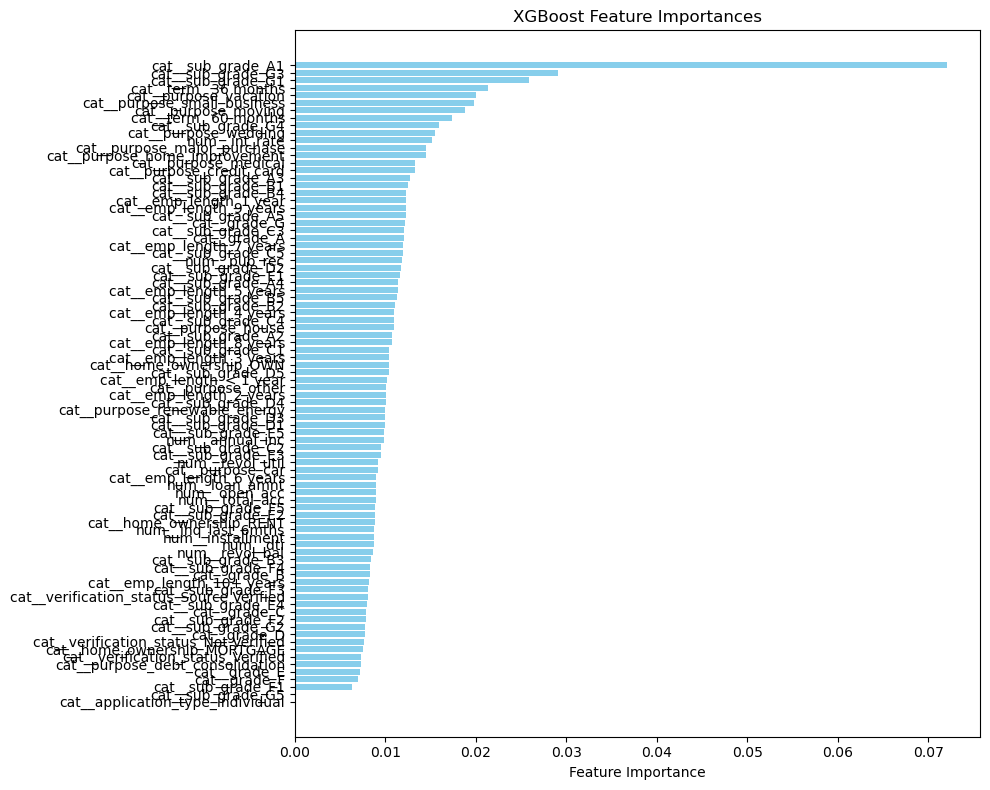

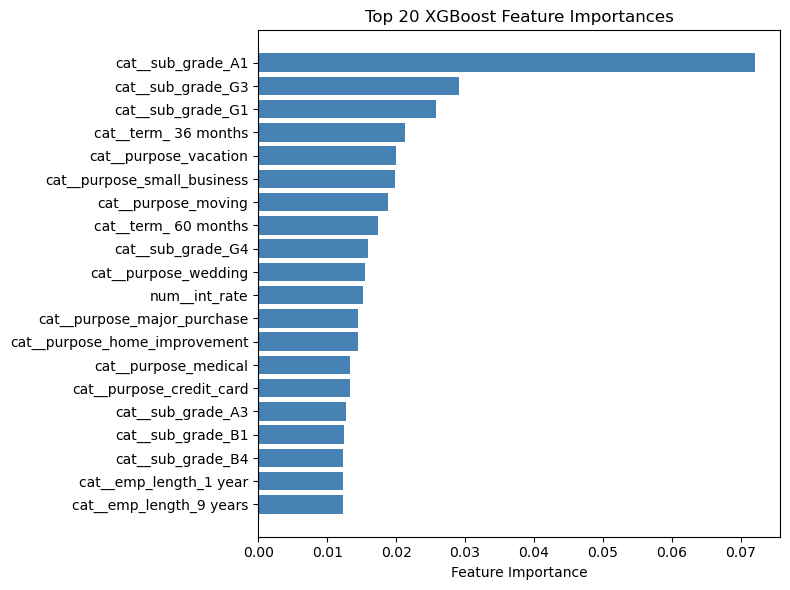

In [8]:

# Get feature names from your ColumnTransformer
feature_names = preprocess.get_feature_names_out()

# Get feature importances from the trained XGBClassifier
importances = xgb_model.feature_importances_

# Put into DataFrame
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=True)

# Plot all features
plt.figure(figsize=(10, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()

# (Optional) Plot only the Top N features
topn = 20
plt.figure(figsize=(8, 6))
top_df = importance_df.tail(topn)
plt.barh(top_df["Feature"], top_df["Importance"], color="steelblue")
plt.xlabel("Feature Importance")
plt.title(f"Top {topn} XGBoost Feature Importances")
plt.tight_layout()
plt.show()
